In [3]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [4]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [12]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Pendulum data-efficiency
query = {"$and": [{"tags": "data-efficiency"},
                  {"state": "finished"},
                  {"config.body_args": [2]},
                  {"config.body_class": "ChainPendulum"}]}

runs, histories = zip(*get_history(query=query))

In [13]:
#trainers = []
#for run in runs:
#    trainer, pl_model = load_model_from_run(run)
#    trainer.model = pl_model
    
#    trainers.append(trainer)
    
#for trainer in trainers:
#    trainer.test()

In [51]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    n_train = run.config["n_train"]
    #n_train = r"$N_{train}$=" + f"{n_train}"
    n_train = n_train

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.numpy()
    avg_rel_err_pert = rel_err_pert_true.numpy()

    series += avg_rel_err_pred.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pred", i) for i in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pert", i) for i in range(len(avg_rel_err_pert))]
    #series.append(avg_rel_err_pert)#
    #labels.append((body, network_class, "avg_rel_err_pert"))

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


In [52]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
index = pd.MultiIndex.from_tuples(labels, names =('n_train', 'Network', "Series", "Batch"))
df = pd.DataFrame(series, index=index).T

In [53]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt

In [54]:
time = pd.Series(np.arange(0, integration_time, dt))
df.index = time

In [55]:
df.head()

n_train             1600                                            \
Network             CHNN                                             
Series  avg_rel_err_pred                                             
Batch                 0             1             2             3    
0.0             0.000000  2.812923e-17  3.718529e-18  3.092304e-17   
0.1             0.000018  1.287743e-05  1.274099e-05  3.275820e-05   
0.2             0.000037  1.776997e-05  2.490260e-05  6.424544e-05   
0.3             0.000057  1.505395e-05  3.594858e-05  7.759122e-05   
0.4             0.000079  1.202558e-05  4.540025e-05  8.315784e-05   

n_train                                                                \
Network                                                                 
Series                                                                  
Batch              4             5         6             7         8    
0.0      3.794961e-18  2.025496e-17  0.000000  1.164691e-17  0.000000   
0.1      5.626947e-05  2.866457e-05  0.000022  8.603971e-05  0.000054   
0.2      1.175639e-04  5.288213e-05  0.000043  1.611000e-04  0.000108   
0.3      1.786592e-04  6.833353e-05  0.000062  2.241873e-04  0.000158   
0.4      2.351255e-04  7.651333e-05  0.000077  2.748152e-04  0.000197   

n_train            ...             100                                 \
Network            ...               NN                                 
Series             ... avg_rel_err_pert                                 
Batch          9   ...               90        91        92        93   
0.0      0.000000  ...         0.000129  0.000055  0.000049  0.000034   
0.1      0.000018  ...         0.000130  0.000057  0.000051  0.000035   
0.2      0.000035  ...         0.000132  0.000060  0.000053  0.000040   
0.3      0.000052  ...         0.000136  0.000063  0.000055  0.000047   
0.4      0.000068  ...         0.000142  0.000065  0.000057  0.000054   

n_train                                                              
Network                                                              
Series                                                               
Batch          94        95        96        97        98        99  
0.0      0.000071  0.000056  0.000077  0.000052  0.000048  0.000098  
0.1      0.000071  0.000057  0.000074  0.000050  0.000049  0.000089  
0.2      0.000067  0.000061  0.000074  0.000050  0.000050  0.000080  
0.3      0.000067  0.000072  0.000076  0.000051  0.000050  0.000071  
0.4      0.000068  0.000089  0.000078  0.000056  0.000051  0.000063  

[5 rows x 4000 columns]

In [56]:
df = df.sort_index(axis=1, level="n_train", ascending=True)

[Text(0, 0.5, 'Rel. Error: $||z - z_{true}||_2 / ||z + z_{true}||_2$')]

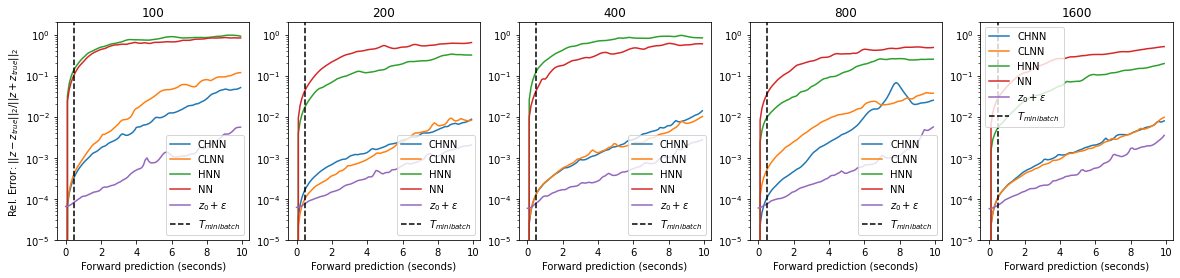

In [57]:
df_batch_avg = df.T.groupby(level=("n_train", "Network", "Series")).mean().T

n_systems = len(df.columns.unique("n_train"))
n_networks = len(df.columns.unique("Network"))

# TODO: uncomment when more than 1 system
fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
#fig, axes = plt.subplots(ncols=2, figsize=(4 * 2, 4))

for system, ax in zip(df.columns.unique("n_train"), axes.flatten()):
    df_batch_avg.loc[:, (system, slice(None), "avg_rel_err_pred")].plot(ax=ax)
    ax.set(yscale="log",
           title=system,
           xlabel=f"Forward prediction (seconds)",
           ylim=(1e-5, 2))
    
    # Just take the perturbation curve from NN
    df_batch_avg.loc[:, (system, "NN", "avg_rel_err_pert")].plot(ax=ax)
    
    ax.axvline(chunk_len, label="Training trajectory length", color="k", linestyle="--")
    
    # TODO: remember to order this correctly if new plots are added
    ax.legend(list(df_batch_avg[system].columns.unique("Network")) + [r"$z_0 + \varepsilon$", r"$T_{minibatch}$"])
axes[0].set(ylabel=r"Rel. Error: $||z - z_{true}||_2 / ||z + z_{true}||_2$")

In [58]:
df_avg_int_err = df.apply(lambda y: np.trapz(np.log(y + 1e-8), dx=dt))
df_avg_int_err = df_avg_int_err.T.groupby(level=("n_train", "Network", "Series")).mean().T
df_avg_int_err.head()

n_train  Network  Series          
100      CHNN     avg_rel_err_pert   -82.963297
                  avg_rel_err_pred   -64.154205
         CLNN     avg_rel_err_pert   -82.585761
                  avg_rel_err_pred   -65.139286
         HNN      avg_rel_err_pert   -84.572239
dtype: float64

[Text(0, 0, '100'),
 Text(0, 0, '200'),
 Text(0, 0, '400'),
 Text(0, 0, '800'),
 Text(0, 0, '1600')]

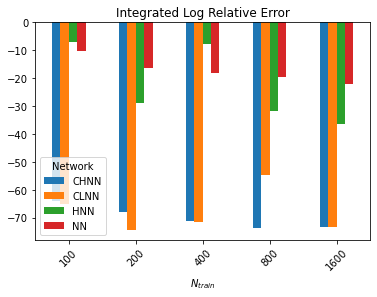

In [61]:
# TODO: uncomment when more than 1 system
#fig, axes = plt.subplots(ncols=n_systems, figsize=(4 * n_systems, 4))
fig, ax = plt.subplots()

df_avg_int_err.loc[(slice(None), slice(None), "avg_rel_err_pred")].unstack().plot(kind='bar', ax=ax)
ax.set(title="Integrated Log Relative Error", xlabel=r"$N_{train}$")
ax.set_xticklabels(list(df_batch_avg.columns.unique("n_train")), rotation=45)

# TODO: remember to order this correctly if new plots are added
#ax.legend(list(df_batch_avg.columns.unique("Network")))